In [1]:
import os
import sys
import re
import matplotlib.pyplot as plt
import peakutils as pku
from lmfit import Parameters
import ImagingReso
root_folder = os.path.dirname(os.getcwd())
sys.path.append(root_folder)
import ResoFit
from lmfit import Parameters
from ResoFit.calibration import Calibration
from ResoFit.fitresonance import FitResonance
import numpy as np
import pprint

In [2]:
# Global parameters
energy_min = 7
energy_max = 150
energy_step = 0.01

In [3]:
# Input sample name or names as str, case sensitive
_layer_1 = 'Gd'
_thickness_1 = 0.15  # mm
mass = 0.36  # gram
length = 25
width = 25
height = 0.075
mm3_to_cm3 = 0.001
density = mass / (length * width * height * mm3_to_cm3)
_density_1 = np.NaN


data_file = 'all_thin.txt'
spectra_file = 'Image002_Spectra.txt'
repeat = 5


source_to_detector_m = 16  # 16#16.445359069030175#16.447496101100739
offset_us = 0  # 0#2.7120797253959119#2.7355447625559037

Name                     Value      Min      Max   Stderr     Vary     Expr Brute_Step
offset_us                2.784     -inf      inf  0.06222     True     None     None
source_to_detector_m     16.45     -inf      inf 0.005108     True     None     None


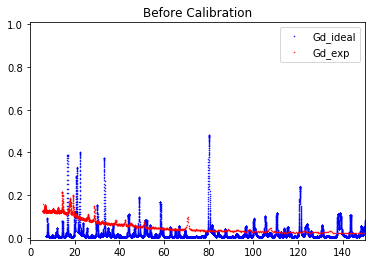

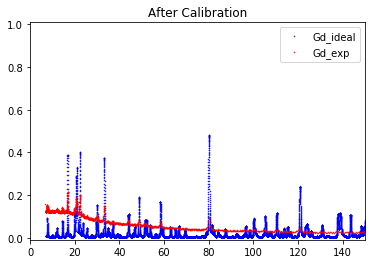

In [4]:
# Calibrate the peak positions
params_calibrate = Parameters()
params_calibrate.add('source_to_detector_m', value=source_to_detector_m, vary=True)
params_calibrate.add('offset_us', value=offset_us, vary=True)

calibration = Calibration(data_file=data_file,
                          spectra_file=spectra_file,
                          layer_1=_layer_1,
                          thickness_1=_thickness_1,
                          density_1=np.NaN,
                          energy_min=energy_min,
                          energy_max=energy_max,
                          energy_step=energy_step,
                          repeat=5)

calibrate_result = calibration.calibrate(params_calibrate=params_calibrate)
calibration.plot_before()
calibration.plot_after()

Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
density        7.68     -inf      inf        0    False     None     None
thickness   0.07218     -inf      inf 0.0008544     True     None     None
Molar conc. of element Gd in layer Gd is: 0.048839427662957076 (mol/cm3)


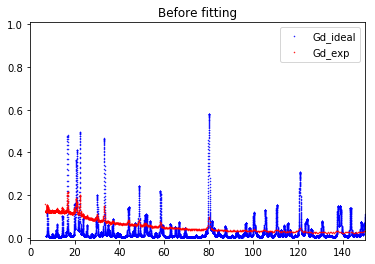

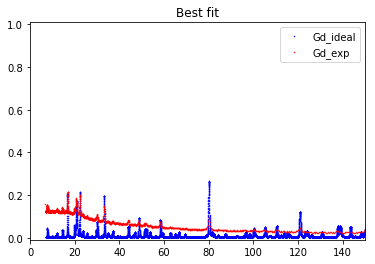

In [5]:
# Fit the peak height
params_fit = Parameters()
params_fit.add('thickness', value=_thickness_1, vary=True)
params_fit.add('density', value=density, vary=False)
fit = FitResonance(spectra_file=spectra_file, data_file=data_file, repeat=repeat, layer=_layer_1,
                   calibrated_offset_us=calibration.calibrated_offset_us,
                   calibrated_source_to_detector_m=calibration.calibrated_source_to_detector_m,
                   energy_min=energy_min, energy_max=energy_max, energy_step=energy_step)
fit.fit(params_fit=params_fit)
fit.molar_conc(_layer_1)
fit.plot_before()
fit.plot_after()